# Optical Character Recognition (OCR) from Scratch

## Introduction
Here, we explore building a basic OCR system using convolutional neural networks. While commercial projects might leverage tools like Tesseract, building from scratch gives insights into the challenges and processes involved.

## Goals/Objectives
- Understand the intricacies of building an OCR model.
- Gain hands-on experience in handling image data and training image classification models.

## Dataset Overview
We'll use the [EMNIST ByClass dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset) for this project. This dataset contains 814,255 characters, both digits and letters.


In [1]:
# install tensorflow dataset
!pip install tensorflow-datasets

# imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np


## Data Loading & Exploration

The EMNIST (Extended MNIST) dataset is an expansion of the original MNIST dataset. The EMNIST ByClass dataset contains 814,255 characters, both digits and letters. It's crucial to first load the dataset and visualize its samples to get a better understanding of the data we are dealing with.

### Personal Notes:
- Always begin by loading and understanding the dataset. Visualization helps to get an intuitive sense of the data.

Let's start by loading the EMNIST dataset and visualizing some samples from it.


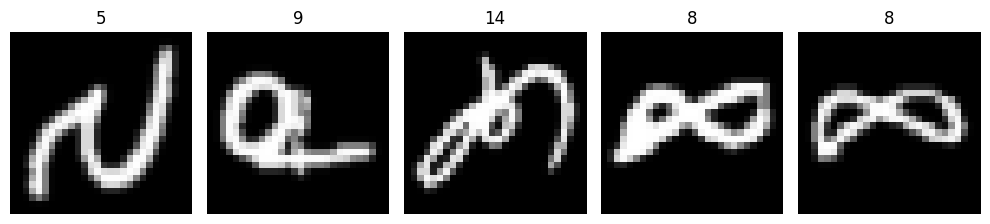

In [2]:

# Load the EMNIST dataset
(train_data, test_data), dataset_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,  # This will return tuple (img, label) otherwise it returns a dictionary
    with_info=True  # Provides tuple containing info about version, features, num_samples
)

# Visualize some sample data from the dataset
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(train_data.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.gray)
    plt.title(label.numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()


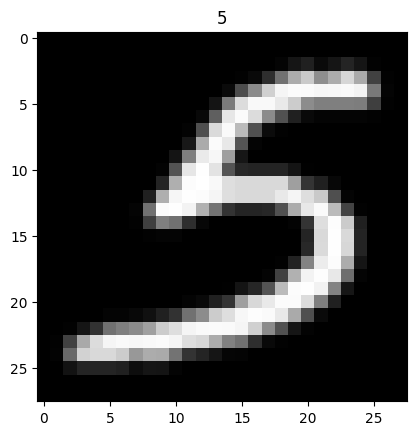

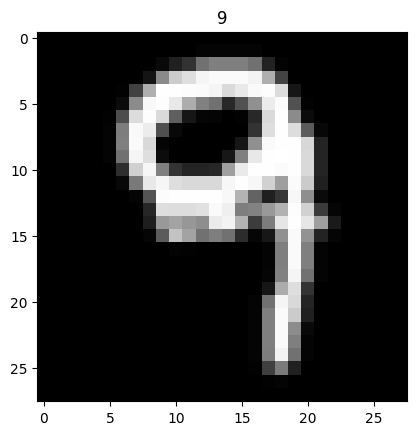

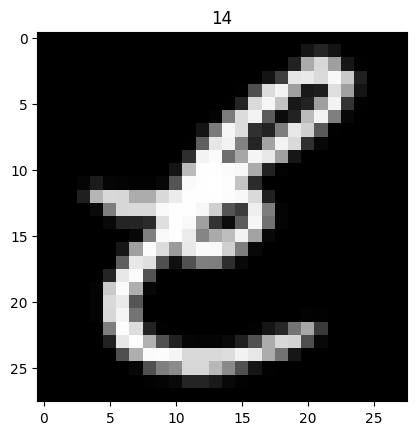

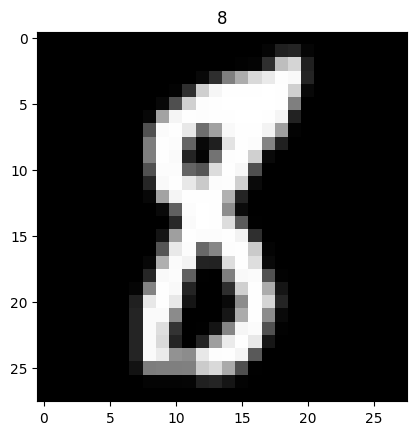

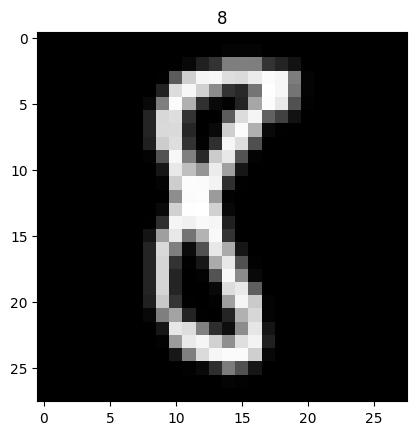

In [3]:
# fix orientation
import numpy as np

for image, label in train_data.take(5):
    # Correct the orientation
    image = np.rot90(image.numpy().squeeze(), -1)
    image = np.fliplr(image)

    plt.figure()
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label.numpy())


## Data Preprocessing

Before we can feed the images into our model, it's crucial to preprocess them to ensure they are in a suitable format. In the case of the EMNIST dataset, the images are rotated, and we need to correct their orientation.

### Personal Notes:
- Image data often requires preprocessing steps such as resizing, normalization, or orientation correction.
- Preprocessing can impact model performance. It's essential to know the dataset's characteristics and apply appropriate preprocessing.

Let's correct the orientation of the images.

#### Normalization

In [4]:
# Access a batch of images and labels from train_data for visualization or processing
for images, labels in train_data.take(1):
    normalized_images = images.numpy() / 255.0

#### Reshaping

In [5]:
# inspect the shape of images in dataset

for images, labels in train_data.take(1):  # Taking one batch from the dataset
    print('Image shape (height, width, channels) : ', images.shape)

Image shape (height, width, channels) :  (28, 28, 1)


Already in the desired shape

*Personal notes: In TensorFlow (and also in numpy), when you're reshaping, the -1 is effectively used as a placeholder that says "whatever is needed", so TensorFlow will automatically compute the correct number for that dimension.*


#### Orientation Correction:

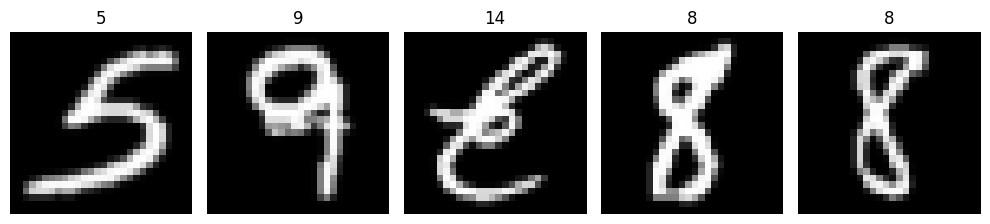

In [6]:

def correct_orientation(image, label):
    # Rotate by 270 degrees (equivalent to -90 degrees) and flip left-right
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    return image, label

corrected_train_data = train_data.map(correct_orientation)

# Visualize some sample data after orientation correction
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(corrected_train_data.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.gray)
    plt.title(label.numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()



## Label Encoding

In machine learning, we often encode categorical labels into a format that could be provided to ML algorithms to do a better job in prediction. One common way is one-hot encoding. One-hot encoding is a process by which categorical variables are converted into a format that can be fed to ML algorithms to improve predictions.

For the EMNIST dataset, the labels represent different classes of characters, and these are categorical. Hence, we need to one-hot encode them.

### Personal Notes:
- One-hot encoding is a process to convert integer labels into a binary matrix. For example, if the dataset has three classes and an input sample belongs to the second class, its one-hot encoded label would be [0, 1, 0].
- This binary matrix representation can be used as input to a neural network.

Let's proceed with the one-hot encoding of the labels.


In [7]:
def encode_labels(image, label):
    # One-hot encode the labels using tf.one_hot
    num_classes = dataset_info.features['label'].num_classes
    one_hot_label = tf.one_hot(label, depth=num_classes)
    return image, one_hot_label

encoded_train_data = corrected_train_data.map(encode_labels)

# Extract a sample for visualization
original_sample = next(iter(tfds.as_numpy(corrected_train_data.take(1))))
encoded_sample = next(iter(tfds.as_numpy(encoded_train_data.take(1))))

original_label = original_sample[1]
one_hot_encoded_label = encoded_sample[1]

original_label, one_hot_encoded_label


(5,
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))


## Balancing the Dataset

Class imbalance is a common problem in machine learning classification. If the number of samples in different classes is imbalanced, the model could be biased towards the class with more samples, leading to suboptimal performance.

In the context of the EMNIST dataset, it's essential to ensure that each character class has roughly the same number of samples.

### Personal Notes:
- An imbalanced dataset can lead the model to be more biased towards the class with more samples. This could result in reduced accuracy for the minority classes.
- Oversampling and undersampling are two common techniques to handle imbalance. Oversampling increases the number of minority class samples, while undersampling reduces the number of majority class samples.

Let's inspect the distribution of classes in our dataset and balance it if necessary.


In [8]:
# Inspect the class distribution
class_distribution = {}

for _, label in tfds.as_numpy(encoded_train_data):
    label_index = np.argmax(label)
    class_distribution[label_index] = class_distribution.get(label_index, 0) + 1

# Display the class distribution
class_distribution


{5: 31416,
 9: 33847,
 14: 4934,
 8: 33946,
 0: 34585,
 7: 35754,
 39: 10177,
 40: 24631,
 1: 38374,
 35: 2701,
 15: 9182,
 3: 35143,
 53: 14105,
 24: 24983,
 31: 4637,
 17: 3152,
 26: 2605,
 52: 2994,
 33: 2771,
 37: 5159,
 42: 3687,
 6: 34232,
 59: 2822,
 43: 8738,
 18: 11946,
 49: 11418,
 34: 4743,
 2: 34203,
 36: 10033,
 47: 15318,
 21: 5076,
 30: 12602,
 38: 2854,
 16: 2517,
 57: 2910,
 32: 4695,
 55: 18262,
 23: 8237,
 4: 33535,
 19: 3762,
 10: 6407,
 27: 5073,
 29: 9820,
 12: 10094,
 60: 2365,
 13: 4562,
 28: 20764,
 48: 2645,
 54: 2699,
 50: 2749,
 45: 1896,
 56: 2830,
 25: 8347,
 41: 2561,
 44: 2725,
 20: 2468,
 61: 2725,
 22: 9002,
 46: 2491,
 58: 2697,
 51: 2448,
 11: 3878}

## Data Augmentation

In deep learning, especially with image data, we can enhance our model's generalization by artificially expanding our training dataset. This is where data augmentation comes into play.

### Personal Notes:
- Data augmentation creates variations of our training data, simulating potential changes the model might see in real-world scenarios.
- While our dataset, EMNIST, is quite large, augmentation can still help in improving model robustness by simulating various handwriting styles and orientations.

### Augmentations Applied:

1. **Random Rotations**: Simulating slight rotations in writing.
2. **Random Zoom**: Capturing variations in handwriting sizes.
3. **Random Translations**: Accounting for slight misalignments in writing.





In [9]:
def augment_data(image, label):
    # Random rotations
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random zoom
    zoom = tf.random.uniform(shape=[], minval=0.9, maxval=1.1)
    image_shape = tf.shape(image)
    new_shape = tf.cast(tf.cast(image_shape[:-1], tf.float32) * zoom, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = tf.image.resize_with_crop_or_pad(image, image_shape[0], image_shape[1])

    # Random translations
    max_shift = tf.cast(tf.cast(tf.shape(image)[0], tf.float32) * 0.1, tf.int32)
    shift_x = tf.random.uniform(shape=[], minval=-max_shift, maxval=max_shift, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-max_shift, maxval=max_shift, dtype=tf.int32)
    image = tf.roll(image, shift=[shift_x, shift_y], axis=[0, 1])

    return image, label

# Applying augmentation to the training data
augmented_train_data = train_data.map(augment_data)


### Personal Notes:
- It's essential to visualize the augmentations to ensure they remain realistic and don't distort the data excessively.
- Augmentations should introduce variability but not make the dataset unrepresentative of real-world data.



This approach to data augmentation should bolster our model's resilience and capability to handle diverse handwriting styles.

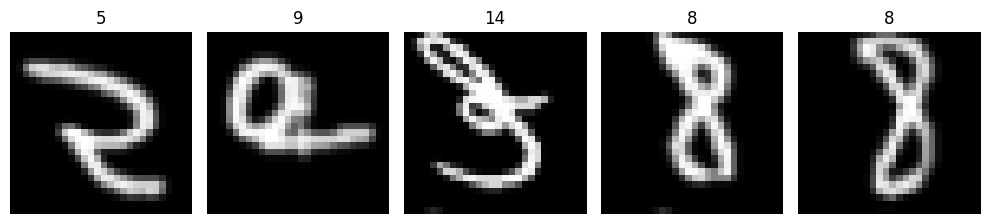

In [10]:
# Visualizing augmented samples
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(augmented_train_data.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.gray)
    plt.title(label.numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()


## Model Architecture

Convolutional Neural Networks (CNNs) have proven to be highly efficient for image classification tasks. Given the hierarchical pattern in data, CNNs can capture this pattern effectively. Our OCR model will comprise:

1. **Convolutional Layers**: To extract feature maps from the images.
2. **Pooling Layers**: To down-sample the feature maps and reduce dimensionality.
3. **Dense Layers**: For classification based on the features extracted by the convolutional layers.
4. **Dropout Layers**: To prevent overfitting by randomly setting a fraction of input units to 0 during training.

### Personal Notes:
- CNNs are designed to automatically and adaptively learn spatial hierarchies of features from images.
- Each convolutional layer typically increases depth and reduces spatial dimensions, capturing more complex features.



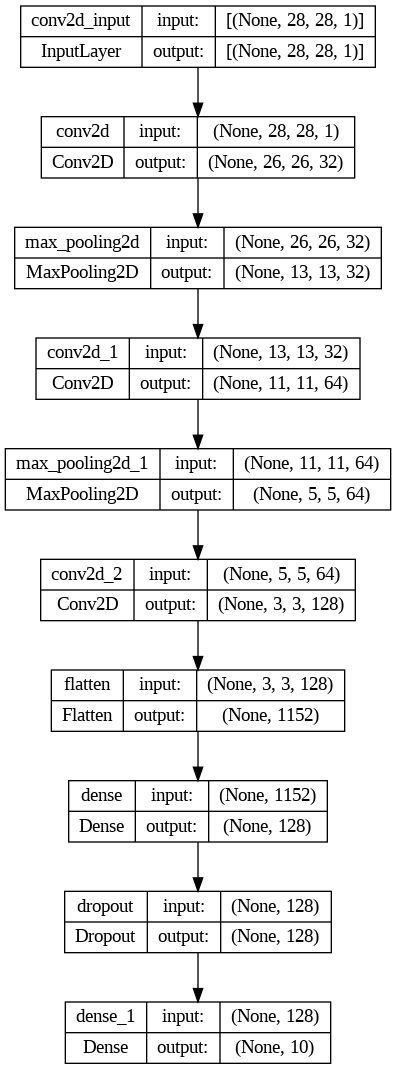

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # REPLACE this 10 with the actual number of unique labels in your dataset
])

# Visualizing the model architecture
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)


### Personal Notes on Model Architecture:

- **Input Layer**: Takes in our grayscale images of size \(28 \times 28\). This is where our handwritten characters go in.
- **Conv2D Layers**: These layers are the essence of our CNN. They apply filters to extract features from the images. We're increasing the depth (32, 64, 128) as we go deeper to capture more intricate patterns.
- **MaxPooling2D Layers**: These guys reduce the spatial dimensions, making computations faster. Also, they introduce some level of translation invariance, which is great for recognizing characters in varying positions.
- **Flatten Layer**: Think of this as unrolling our 3D feature maps into 1D. It's the bridge between our convolutional and dense layers.
- **Dense Layers**: The first one (with 128 neurons) is for intricate pattern recognition. The second one corresponds to our classes. It tells us the probability of each class being the correct prediction for the input image.
- **Dropout Layer**: A neat trick to prevent our model from memorizing the training data (overfitting). It randomly turns off 50% of the neurons during training, making our model more robust.


## Training

Training a deep learning model involves multiple steps:
1. **Dataset Splitting**: We'll reserve some data for validation to assess the model's performance during training.
2. **Compilation**: Define a loss function, an optimizer, and metrics for monitoring during training.
3. **Model Training**: We'll use the training data and validate the model's performance with the validation data.

### Personal Notes:
- It's crucial to monitor validation metrics during training to ensure the model isn't overfitting.
- The optimizer adjusts the model's weights based on the computed loss.



In [15]:
# Determine the number of unique labels in the dataset
unique_labels = set()
for _, label in train_data:
    unique_labels.update([label.numpy()])
num_classes = len(unique_labels)

# Adjust the model architecture to have the correct number of output neurons
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Adjusted to the correct number of classes
])

# Compilation using sparse categorical crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
17449/17449 [==============================] - 715s 41ms/step - loss: 0.7135 - accuracy: 0.7808 - val_loss: 0.4640 - val_accuracy: 0.8386
Epoch 2/10
17449/17449 [==============================] - 710s 41ms/step - loss: 0.5240 - accuracy: 0.8249 - val_loss: 0.4438 - val_accuracy: 0.8452
Epoch 3/10
17449/17449 [==============================] - 657s 38ms/step - loss: 0.5097 - accuracy: 0.8290 - val_loss: 0.4450 - val_accuracy: 0.8448
Epoch 4/10
17449/17449 [==============================] - 709s 41ms/step - loss: 0.5054 - accuracy: 0.8299 - val_loss: 0.4415 - val_accuracy: 0.8460
Epoch 5/10
17449/17449 [==============================] - 709s 41ms/step - loss: 0.5025 - accuracy: 0.8315 - val_loss: 0.4400 - val_accuracy: 0.8470
Epoch 6/10
17449/17449 [==============================] - 654s 37ms/step - loss: 0.5018 - accuracy: 0.8315 - val_loss: 0.4426 - val_accuracy: 0.8462
Epoch 7/10
17449/17449 [==============================] - 647s 37ms/step - loss: 0.5049 - accuracy: 0.8309

## Evaluation

Post-training, it's essential to evaluate our model on new, unseen data to gauge its performance reliably. We'll assess its accuracy, visualize some predictions, and discuss any misclassifications.

### Personal Notes:
- Evaluation provides insights into the model's real-world applicability.
- It's vital to understand where the model might make mistakes to further improve or fine-tune it.



In [16]:
# Evaluating the model on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# TODO: Add code for visual examples of predictions, contrasting predictions against actual labels


4363/4363 [==============================] - 96s 12ms/step - loss: 0.4694 - accuracy: 0.8399
Validation Accuracy: 83.99%


### Visualizing Model Predictions

Below are some examples from the validation set. The title of each image displays the actual label and the model's prediction. Correct predictions are colored in blue, while incorrect predictions are in red.


1/1 [==============================] - 0s 167ms/step


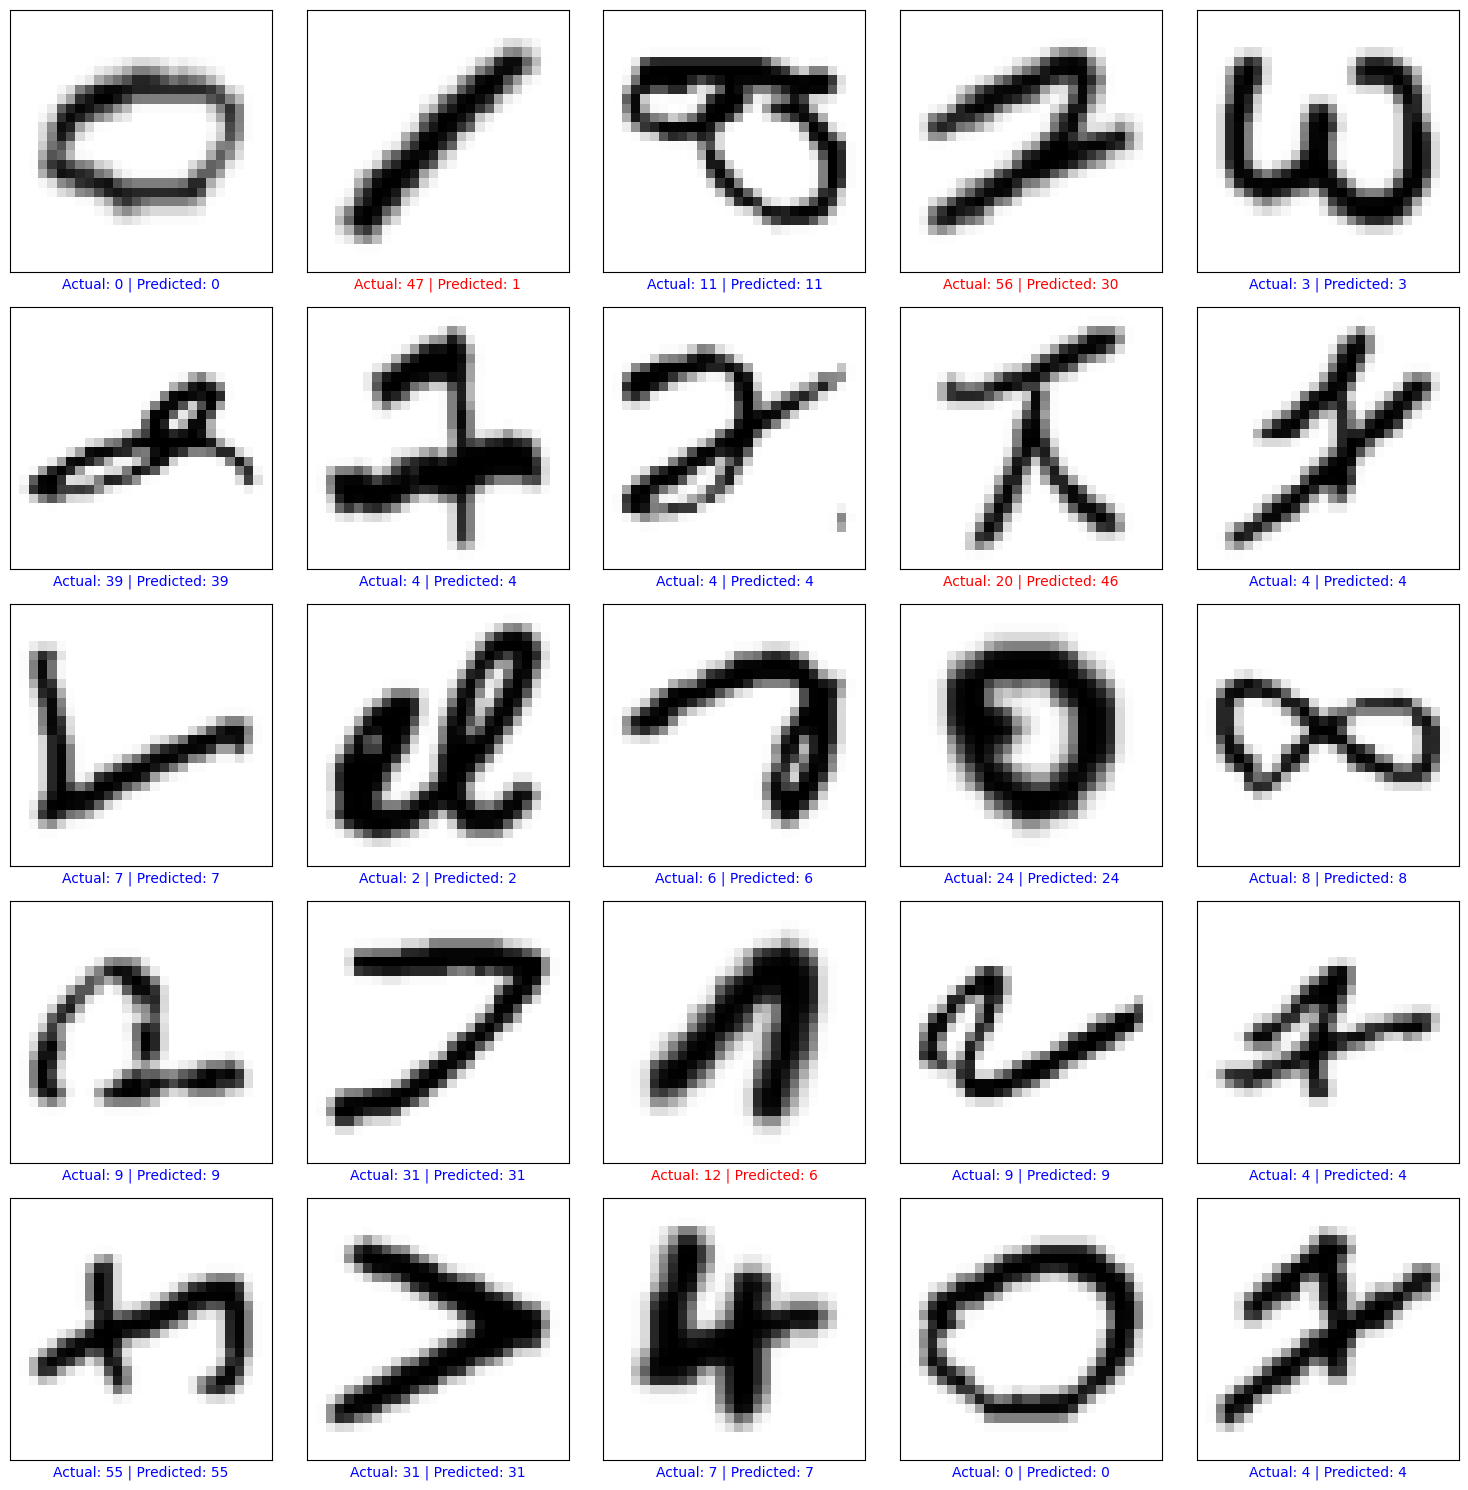

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Displaying some predictions vs. actual labels
for val_images, val_labels in val_dataset.take(1):  # Taking one batch from the validation dataset
    predictions = model.predict(val_images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(25):  # Displaying 25 images from the batch
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(val_images[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
        actual_label = val_labels[i].numpy()
        predicted_label = predicted_labels[i]
        color = 'blue' if actual_label == predicted_label else 'red'
        plt.xlabel(f"Actual: {actual_label} | Predicted: {predicted_label}", color=color)
    plt.tight_layout()
    plt.show()


## Conclusion

Through this notebook, we embarked on a journey to build an OCR system from scratch using deep learning.

### Personal Notes:
- Building a model from scratch provides invaluable insights, even if pre-built solutions like Tesseract exist.
- Potential Improvements:
    - Refining the model architecture or experimenting with more advanced architectures.
    - Implementing advanced training techniques.
    - Exploring other datasets to enhance the model's understanding.
- Future Directions:
    - Delving into more sophisticated OCR techniques.
    - Integrating our model into practical applications.
    - Benchmarking our model against established tools like Tesseract.

